In [529]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import warnings
print(torch.__version__)
warnings.filterwarnings("ignore")

BATCH_SIZE = 16
DATA_SET = 'MPQA'
N_EPOCHS = 26

print("DATA_SET:", DATA_SET)
CUDA_NUMBER = 0

# 0-->MR ||  1-->CR ||  2-->SST  ||  3-->SUBJ ||  4-->MPQA
dataset_dict = {}
dataset_dict['MR'] = 0
dataset_dict['CR'] = 1
dataset_dict['SST'] = 2
dataset_dict['SUBJ'] = 3
dataset_dict['MPQA'] = 4

# 设置要训练的数据集
DATASET_NUMBER = dataset_dict[DATA_SET]

train_path_ls = []
test_path_ls = []
word_vector_path_ls = []
train_path_ls.append("./DataSet/MR/train.tsv")
train_path_ls.append("./DataSet/CR/train.tsv")
train_path_ls.append("./DataSet/SST/train.tsv")
train_path_ls.append("./DataSet/SUBJ/train.tsv")
train_path_ls.append("./DataSet/MPQA/train.tsv")

test_path_ls.append("./DataSet/MR/test.tsv")
test_path_ls.append("./DataSet/CR/test.tsv")
test_path_ls.append("./DataSet/SST/test.tsv")
test_path_ls.append("./DataSet/SUBJ/test.tsv")
test_path_ls.append("./DataSet/MPQA/test.tsv")

word_vector_path_ls.append("./sub_word_vector/MR_word_vector.txt")
word_vector_path_ls.append("./sub_word_vector/CR_word_vector.txt")
word_vector_path_ls.append("./sub_word_vector/SST_word_vector.txt")
word_vector_path_ls.append("./sub_word_vector/SUBJ_word_vector.txt")
word_vector_path_ls.append("./sub_word_vector/MPQA_word_vector.txt")

# 要训练的任务级路径
train_path = train_path_ls[DATASET_NUMBER]
test_path = test_path_ls[DATASET_NUMBER]

# 词向量和W2Idx的路径
word_vector_path = word_vector_path_ls[DATASET_NUMBER]

2.0.0+cu118
DATA_SET: MPQA


In [530]:
word_dim = 100 # 词向量维度
# 获取单词到索引的映射表以及每个单词的词向量表

word_to_index = {'<unknown>': 0, '<padded>': 1}  # 根据筛选出来的词向量文件"word_vector.txt" 生成单词和索引的字典
zero_ls = [0.0 for i in range(word_dim)]
ls = [zero_ls, zero_ls]  # 用一个列表ls来存储词向量 前两个分别是 100 维的0向量，用来表示unknown_token和pad_token
index_to_word = {}
with open(word_vector_path, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        # 将刑如 "the -0.038194 -0.24487 0.72812 -0.39961..."的字符串分成对应的词和词向量，比如"the"， "-0.038194 -0.24487 0.72812 -0.39961..."
        #并且构建单词映射到整数的字典，word_to_index。 eg. 'the' : 2  ，PS：0和1分别是两个特殊字符串 unknown 和 padded的索引，the作为词向量文件中的第一个单词，所以下标为2
        word_vector = line.split()
        word_to_index[word_vector[0]] = i + 2  # 前两位由unknown和 padded分别占据
        tmp = [] # 存储一个单词的词向量，总共是100个数字
        for j, word in enumerate(word_vector):
            if j == 0: #第一个是单词，所以跳过，只需要每个单词后面的词向量
                continue
            tmp.append(float(word))
        ls.append(tmp) #每个单词的词向量又存到列表ls当中
for key, value in word_to_index.items():
    index_to_word[value] = key

word_vector_weight_matrix = torch.FloatTensor(ls) #将词向量列表转换为Tensor
print(word_vector_weight_matrix.size())
print(word_vector_weight_matrix.shape[0])
print(len(word_to_index))#word_to_index字典的关键字是英语单词，值是单词索引，例如{'<unknown>': 0,'<padded>': 1,'the': 2,',': 3,'.': 4,...}
VOCAB_SIZE = len(word_to_index) + 2

torch.Size([5568, 100])
5568
5568


In [531]:
import torch
import random
from nltk.corpus import wordnet
import nltk

# 导入AFINN情感词典
# from afinn import Afinn

# 创建Afinn对象
# afinn = Afinn()

# 1、【将句子分词，并且求句子长度】
def get_sentences(path):
    sentences = []
    batch_sentences = []
    with open(path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            # 跳过第一行的test label
            if i == 0:
                continue
            words = line.split()[:-1]  # 需要将末尾的0或者1去掉
            label = float(line.split()[-1])
            count = 0  # 统计每个句子的长度
            for word in words:
                count += 1
            tmp = (words, count, label)
            sentences.append(tmp)
    return sentences


# 根据上面得到的word_to_index,将单词转换为数字,列表形式为[ ([words_list1], len1, label1), ([words_list2], len2, label2),......],
# word_list是多个单词组成的序列

# 2、【将分词之后的单词序列变成数字序列】
def lookup_table(array_ls, word_to_index):
    sentences_tensor = []
    for i, sentence in enumerate(array_ls):
        tensor_ls = []
        # sentence[0]是一个包含多个单词的列表。sentence[0]是一个列表，里面的元素是单词。
        for word in sentence[0]:
            # word_to_index 是一个单词到索引的字典
            if word in word_to_index.keys():
                tensor_ls.append(word_to_index[word])  # 将单词转换为索引，并且索引存入张量当中
            else:
                tensor_ls.append(1)  # 如果在索引表中没找到单词，则“不认识”单词,用1下标代替, 此时unknown_token和padded_token下标都是1
        sentences_tensor.append((tensor_ls, sentence[1], sentence[2]))
    return sentences_tensor  # 得到的列表形式为[([3,8,12,123,2,9],6,1),([6,45,652345,634,2342,4],6,0)]


# 对句子进行填充，eg:16个句子组成一个batch,【每个batch的句子长度必须相等】，这里的做法是，获取batch中长度最长的句子,然后句子长度不够的append 1
# 输入 [([单词下标]，句子长度1, 标签1), ([单词下标]，句子长度2, 标签2), ....]
# eg. [([1, 2, 3],3, 0), ([2, 3], 2, 1), ...]
# 输出，[([单词下标]，句子长度1, 标签1), ([单词下标]，句子长度2, 标签2), ....]
# eg. 假设batch_size = 2
# [([1, 2, 3], 3), ([2, 3, 1], 2),...] 第二个句子列表 append 1，但是实际长度为2

# 3、【将句子进行分batch，并且将数字列表（句子）进行填充】
def pad_sentence_plus(array_ls, array_sentiment, batch_size):  # 这里的array_ls是上面函数的输出，即sentences_tensor。
    ans = 0  # j记录每个batch的第一条数据的下标
    max = array_ls[0][1]  # max为每个batch的句子最大长度.
    # 第一维为列表的第几个元素（即一个句子元组），第二维为一个元组的第一个元素（即一个元组里面的word_list），这里max初始化为第一个句子的长度。
    for i in range(len(array_ls)):
        # 需要考虑最后一个batch可能长度不够batch_size
        if (i + 1) % batch_size == 0 or i == len(array_ls) - 1:
            if array_ls[i][1] > max:
                max = array_ls[i][1]
            if (i + 1) % batch_size == 0:
                index = batch_size
            else:
                index = i - ans + 1
            for j in range(index):
                while len(array_ls[j + ans][0]) < max:
                    array_ls[j + ans][0].append(1)
                    array_sentiment[j + ans] += [0]
            # 每一次填充完毕后，需要更新标记，并再次初始化最大值
            ans = i + 1
            if ans != len(array_ls):
                max = array_ls[ans][1]
        else:
            if array_ls[i][1] > max:  # 取句子的最大长度
                max = array_ls[i][1]
    return array_ls, array_sentiment


# 输入，[([单词下标]，句子长度1, 标签1), ([单词下标]，句子长度2, 标签2), ....]
# [([1, 2, 3],3), ([2, 3, 1], 2),...]
# shuffle表示是否将每个batch打乱
# batch_first if false 表示返回的张量形状为(sentence_len,batch_size)
# if true 表示返回的张量形状为(batch_size,sentence_len)
# 这里默认采用batch_first = False,主要是为了适应nn.Embedding层的输入形状

# 4、【获得embedding的一个个batch（调整batch的的形状）的数据迭代器】
def iterator(array_ls, array_sentiment, batch_size, shuffle=True, batch_first=False):
    sentences_index_label_sentiment = []  # 存放填充后的语句列表【句子的indx表示】
    tmp_sen = []
    tmp_label = []
    tmp_sentiment = []
    for i, sentence in enumerate(array_ls):
        tmp_sen.append(sentence[0])  # 存放一个batch的【数据】
        tmp_label.append(sentence[2])  # 存放一个batch的【标签】
        tmp_sentiment.append(array_sentiment[i])
        if (i + 1) % batch_size == 0:  #
            sentences_index_label_sentiment.append((tmp_sen, tmp_label, tmp_sentiment))
            tmp_sen = []  # 清空数据
            tmp_label = []  # 清空标签
            tmp_sentiment = []

    # 最后几个样本可能不够一个batch,需要额外判断
    if len(tmp_sen) != 0:
        # # 补齐
        # for _ in range(batch_size - len(tmp_sen)):
        #     tmp_sen.append(sentence[0])
        #     tmp_label.append(sentence[2])
        #     tmp_sentiment.append(array_sentiment[1])
        sentences_index_label_sentiment.append((tmp_sen, tmp_label, tmp_sentiment))
        # # OR去掉
        # break

    if shuffle:
        random.shuffle(sentences_index_label_sentiment)  # 打乱列表中各个batch的顺序
    res = []
    # 2D张量转置
    # 2D张量转置
    if batch_first == False:
        for batch in sentences_index_label_sentiment:
            res.append((torch.LongTensor(batch[0]).t(), torch.FloatTensor(batch[1]),
                        torch.FloatTensor(batch[2]).t()))  # 函数t()求矩阵的转置
    else:
        for batch in sentences_index_label_sentiment:
            res.append((torch.LongTensor(batch[0]).t(), torch.FloatTensor(batch[1]), torch.FloatTensor(batch[2]).t()))
    return res

In [532]:
import torch
import random
from nltk.corpus import wordnet, sentiwordnet
# 下载 SentiWordNet 数据
# nltk.download('sentiwordnet')
# 加载 SentiWordNet 数据
swn_file_path = nltk.data.find('corpora/sentiwordnet/SentiWordNet_3.0.0.txt')

In [533]:
# =====================================================================================
# ================================= sentiwordnet ======================================
# =====================================================================================


def get_sentiment_score(word):
    """获取WordNet情感分数"""

    synsets = list(wordnet.synsets(word))
    if synsets:
        sentiment_scores = [
            sentiwordnet.senti_synset(s.name()).pos_score() - sentiwordnet.senti_synset(s.name()).neg_score()
            for s in synsets
        ]
        avg_sentiment_score = sum(sentiment_scores) / len(sentiment_scores)
        return avg_sentiment_score
    return 0.0


def get_word_sentiment_scores(tokenized_sentence):
    """计算已分词句子中每个单词的情感极性分数"""
    # 处理否定词
    word_scores = [get_sentiment_score(word) for word in tokenized_sentence]
    return word_scores


def get_batch_word_sentiment_scores(batch_tokenized_sentences):
    """处理一批已分词的文本并返回其中每个单词的情感极性分数"""
    batch_word_scores = []
    for sentence, _, _ in batch_tokenized_sentences:
        batch_word_scores.append(get_word_sentiment_scores(sentence))
    return batch_word_scores

In [534]:
SEED = 1234

torch.manual_seed(SEED) # 为CPU设置随机种子，生成随机数，使得每次运行程序时，生成的随机数相同
torch.cuda.manual_seed(SEED) # 为GPU设置随机种子，生成随机数，使得每次运行程序时，生成的随机数相同
torch.backends.cudnn.deterministic = True

device = torch.device(f'cuda:{CUDA_NUMBER}' if torch.cuda.is_available() else 'cpu')

In [535]:
def get_iterator(path, batch_size, word_to_index):
    # ['another', 'thing', 'i', 'don', "'t", 'like', 'is', 'that', 'some', 'of', 'the',
    # 'features', 'take', '1-2', 'seconds', 'to', 'load', 'up', '.']
    sentences = get_sentences(path)
    # ([2, 3, 4, 5, 1, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
    # 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 19, 0.0)
    # 将单词变成indx
    sentences_indx = lookup_table(sentences, word_to_index)

    # get sentiment polarity by 【AFINN】
    # afinn = Afinn()
    # sentiment_sentences_AFINN = get_batch_word_sentiment_scores_AFINN(sentences,afinn)
    # sentiment_sentences_AFINN = calculate_sentiment_for_phrases(sentences, afinn, n=3)

    # get sentiment polarity by 【sentiwordnet】
    sentiment_sentences_sentiwordnet = get_batch_word_sentiment_scores(sentences)
    sentences_padded, sentiment_sentences_padded = pad_sentence_plus(sentences_indx, sentiment_sentences_sentiwordnet,
                                                                     batch_size)

    # 把分成一个个batch，然后每个list之内有数据和标签
    Iterator_with_sentiments = iterator(sentences_padded, sentiment_sentences_padded, batch_size)

    return Iterator_with_sentiments

# 2、生成对应任务的句子的词向量
train_iterator = get_iterator(train_path, BATCH_SIZE, word_to_index)
test_iterator = get_iterator(test_path, BATCH_SIZE, word_to_index)

In [536]:
import torch.nn as nn
import numpy as np
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch

In [537]:
class projection_Euler(nn.Module):
    def __init__(self, Embedding, num_layers):
        super(projection_Euler, self).__init__()  # projection是子类名
        pass

    def forward(self, inputs):
        amplitude = inputs[0]
        phase = inputs[1]
        # ================ 变换形状和归一化处理 ================
        # -----
        amplitude_permute = amplitude.permute(1, 0, 2)
        amplitude_norm = F.normalize(amplitude_permute, 2, 2)
        # ----
        phase_permute = phase.permute(1, 0, 2)

        # ================ 计算Am和Ph分别计算实部和虚部 ================
        # --- 求欧拉展开式
        real_part = amplitude_norm * torch.cos(phase_permute)
        imag_part = amplitude_norm * torch.sin(phase_permute)

        return [real_part, imag_part]


class projection_CalculateMatrixMean(nn.Module):
    def __init__(self, Embedding_dim):
        super(projection_CalculateMatrixMean, self).__init__()
        self.mapping_Diagonal_q = nn.Linear(Embedding_dim, Embedding_dim)
        self.mapping_Diagonal_k = nn.Linear(Embedding_dim, Embedding_dim)

        self.embed_size = Embedding_dim

    def forward(self, inputs):
        Diagonal1 = inputs[0]
        Diagonal2 = inputs[1]
        Matrix = inputs[2]

        # 计算注意力分数
        attention_scores = Diagonal1 * Diagonal2
        # 迹求和
        attention_weight = torch.sum(attention_scores, dim=-1)

        # 归一化
        attention = F.softmax(attention_weight, dim=-1).unsqueeze(-1).unsqueeze(-1)

        # 加权求和
        Matrix_output = torch.sum(Matrix * attention, dim=1)

        return Matrix_output


class projection_CalculateMatrixQ(nn.Module):
    def __init__(self, Embedding_dim):
        super(projection_CalculateMatrixQ, self).__init__()
        self.Q_Linear_real1 = nn.Linear(Embedding_dim, Embedding_dim)
        self.Q_Linear_imag1 = nn.Linear(Embedding_dim, Embedding_dim)

        self.Q_Linear_real2 = nn.Linear(Embedding_dim, Embedding_dim)
        self.Q_Linear_imag2 = nn.Linear(Embedding_dim, Embedding_dim)

        self.AttentionReal = projection_CalculateMatrixMean(Embedding_dim)
        self.AttentionImag = projection_CalculateMatrixMean(Embedding_dim)

    def forward(self, inputs):
        input_real = inputs[0]  # 实部
        input_imag = inputs[1]  # 虚部
        # ==================== 1 计算对角线和密度矩阵 ====================

        # ======= 1.1 计算对角线 =======
        input_real1 = self.Q_Linear_real1(input_real)
        input_imag1 = self.Q_Linear_imag1(input_imag)

        # 获得[实部/虚部]对角线向量
        diagonal_real1 = input_real1 * input_real1 - input_imag1 * input_imag1
        diagonal_imag1 = input_real1 * input_imag1 + input_imag1 * input_real1

        # ======= 1.2 计算密度矩阵 =======
        input_real2 = self.Q_Linear_real2(input_real)
        input_imag2 = self.Q_Linear_imag2(input_imag)

        diagonal_real2 = input_real2 * input_real2 - input_imag2 * input_imag2
        diagonal_imag2 = input_real2 * input_imag2 + input_imag2 * input_real2

        real_part_expand = torch.unsqueeze(input_real2, dim=3)
        imag_part_expand = torch.unsqueeze(input_imag2, dim=3)

        real_part_expand_transpose = real_part_expand.permute(0, 1, 3, 2)
        imag_part_expand_transpose = imag_part_expand.permute(0, 1, 3, 2)

        # real 密度矩阵
        Matrix_real = torch.matmul(real_part_expand, real_part_expand_transpose) - torch.matmul(imag_part_expand,
                                                                                                imag_part_expand_transpose)
        # imag 密度矩阵
        Matrix_imag = torch.matmul(imag_part_expand, real_part_expand_transpose) + torch.matmul(real_part_expand,
                                                                                                imag_part_expand_transpose)

        Matrix_Real_output = self.AttentionReal([diagonal_real1, diagonal_real2, Matrix_real])
        Matrix_imag_output = self.AttentionImag([diagonal_imag1, diagonal_imag2, Matrix_imag])

        return [Matrix_Real_output, Matrix_imag_output]


class projection_Measurement(nn.Module):
    def __init__(self, Embedding_dim):
        super(projection_Measurement, self).__init__()  # projection是子类名
        # 使得tensor是正交的,正交初始化,projector是子类projection的新属性。
        self.projector = nn.init.orthogonal_(Parameter(torch.Tensor(2, Embedding_dim, 1)))

    def forward(self, inputs):
        v_real_avg = inputs[0]
        v_imag_avg = inputs[1]

        p_real = self.projector[0]
        p_imag = self.projector[1]

        p_real_norm = p_real / torch.norm(p_real, dim=0)
        p_imag_norm = p_imag / torch.norm(p_imag, dim=0)

        p_real_mat = torch.matmul(p_real_norm, p_real_norm.permute(1, 0))
        p_imag_mat = torch.matmul(p_imag_norm, p_imag_norm.permute(1, 0))

        Pv_real = torch.matmul(v_real_avg, p_real_mat) - torch.matmul(v_imag_avg, p_imag_mat)
        Pv_imag = torch.matmul(v_real_avg, p_imag_mat) + torch.matmul(v_imag_avg, p_real_mat)

        Pv_real_plus = torch.unsqueeze(Pv_real, dim=1)
        Pv_imag_plus = torch.unsqueeze(Pv_imag, dim=1)

        return [Pv_real_plus, Pv_imag_plus]

In [538]:
# 映射成三个不同的向量的自注意力机制
class self_attention(nn.Module):
    def __init__(self, Embedding_dim):
        super(self_attention, self).__init__()
        self.mapping_query = nn.init.uniform_(
            Parameter(torch.Tensor(Embedding_dim, Embedding_dim)))  # 从均匀分布U(a, b)中生成值（随机生成），填充输入的张量或变量
        self.mapping_key = nn.init.uniform_(Parameter(torch.Tensor(Embedding_dim, Embedding_dim)))
        self.mapping_value = nn.init.uniform_(Parameter(torch.Tensor(Embedding_dim, Embedding_dim)))

    def forward(self, inputs):
        query = torch.matmul(inputs.permute(1, 0, 2), self.mapping_query)  # permute函数为换维函数，参数为(0，1，2)
        key = torch.matmul(inputs.permute(1, 0, 2), self.mapping_key)  # matmul是tensor矩阵乘法
        value = torch.matmul(inputs.permute(1, 0, 2), self.mapping_value)

        query = query / torch.norm(query, dim=2).reshape(query.shape[0], query.shape[1],
                                                         1)  # query.shape[0]=16,query.shape[1]=sentence_length.
        key = key / torch.norm(key, dim=2).reshape(key.shape[0], key.shape[1],
                                                   1)  # shape of tensor:[16,sentence_length,1]

        value = value / torch.norm(value, dim=2).reshape(value.shape[0], value.shape[1], 1)  # query,key,value的形状是一样的

        xx = torch.matmul(query, torch.transpose(key, 1, 2)) / np.sqrt(inputs.shape[1])
        xx1 = torch.softmax(xx, dim=2)
        out = torch.matmul(xx1, value)
        return out

In [539]:
class GRUWithSkipConnection(nn.Module):
    def __init__(self, Embedding_dim, num_layers):
        super(GRUWithSkipConnection, self).__init__()

        # GRU layer
        self.rnn = nn.GRU(Embedding_dim, Embedding_dim, num_layers=num_layers, dropout=0.1)

        # self.scale_layer = nn.Linear(2 * Embedding_dim, Embedding_dim)

        # Linear layer for skip connection
        self.middle_layer = nn.Linear(Embedding_dim, Embedding_dim)

    def forward(self, x):
        # Forward pass through GRU layer
        output, _ = self.rnn(x)

        # Skip connection: Add output of middle layer to GRU layer output
        output = output + self.middle_layer(x)

        return output

In [540]:
# -------------------- 01 Model_best_copy8672_cnn_maxpooling ------------------------
print("Model_best_copy8672_cnn_maxpooling")
class run_complex_network(nn.Module):
    def __init__(self, weight_matrix, embedding_dim, hidden_dim, output_dim, num_layers, pad_idx, VOCAB_SIZE, batch):
        super().__init__()

        # ================ 1、词嵌入模块 ================
        # ------ 实部，预训练模型 -------
        self.amplitude_embedding = nn.Embedding.from_pretrained(weight_matrix, padding_idx=pad_idx, freeze=False)
        # self.amplitude_embedding2 = nn.Embedding(VOCAB_SIZE, embedding_dim, padding_idx=pad_idx)

        # ------ 虚部，传统模型 -------
        # self.phase_embedding = nn.Embedding.from_pretrained(weight_matrix, padding_idx=pad_idx, freeze=False)
        # self.phase_embedding = nn.Embedding(VOCAB_SIZE, embedding_dim, padding_idx=pad_idx)
        # self.phase_embedding_sentiment = nn.Embedding(VOCAB_SIZE, embedding_dim, padding_idx=pad_idx)

        # ================ 2、GRU模块 信息提取 ================
        # 输出张量的维度(L:sequence_length,N:batch_size,hidden_size)
        self.gru1 = GRUWithSkipConnection(embedding_dim, num_layers)
        self.gru2 = GRUWithSkipConnection(embedding_dim, num_layers)

        self.self_attention1 = self_attention(Embedding_dim=embedding_dim)
        # ================ 3、计算密度矩阵 ================

        self.projection_Euler = projection_Euler(Embedding=embedding_dim, num_layers=num_layers)
        self.projection_CalculateMatrixattension = projection_CalculateMatrixQ(Embedding_dim=embedding_dim)
        self.projection_measurement = projection_Measurement(embedding_dim)

        # ================ 4、卷积 ================
        self.Conv2dOne = nn.Conv2d(1, 1, 3)  # 实部
        self.Conv2dTwo = nn.Conv2d(1, 1, 3)  # 虚部

        # ================ 5、池化 ================

        self.MaxPool1 = nn.MaxPool2d((embedding_dim - 2, 1), 1)  # 实部
        self.MaxPool2 = nn.MaxPool2d((embedding_dim - 2, 1), 1)  # 虚部

        # ================ 6、全连接层 ================
        self.fc1 = nn.Linear(2 * (embedding_dim - 2), 10)
        self.fc2 = nn.Linear(10, output_dim)

    def forward(self, text, sentiment):
        # ================ 1、文本嵌入到向量 ================
        amplitude_is_WordEmbedding = self.amplitude_embedding(text)

        sentiment_unsqueeze = (torch.unsqueeze(sentiment, dim=-1).
                               expand(*sentiment.shape, amplitude_is_WordEmbedding.size(2)))

        phase_is_sentiment = sentiment_unsqueeze

        # ================ 2、实部进行GRU处理 ================
        amplitude_plus = self.gru1(amplitude_is_WordEmbedding)
        amplitude_plus2 = self.self_attention1(amplitude_plus)
        amplitude_plus2 = amplitude_plus2.permute(1, 0, 2)

        phase_plus = self.gru2(phase_is_sentiment)

        # ================ 3、计算密度矩阵 ================
        embedded = [amplitude_plus2, phase_plus]

        Euler_realAimag = self.projection_Euler(embedded)
        Matrix_realAimag = self.projection_CalculateMatrixattension(Euler_realAimag)
        Project_realAimag = self.projection_measurement(Matrix_realAimag)

        MatrixReal = Project_realAimag[0]
        MatrixImag = Project_realAimag[1]

        # ================ 4、卷积操作 ================
        # 5.1 --对于【实部】进行卷积
        Conv_real = self.Conv2dOne(MatrixReal)
        # 5.2 --对于【虚部】进行卷积
        Conv_imag = self.Conv2dTwo(MatrixImag)

        # ================ 5、池化操作 ================
        # 6.1 --对于【实部】进行池化
        Max_real = self.MaxPool1(torch.sigmoid(Conv_real))
        # 6.2 --对于【虚部】进行池化
        Max_imag = self.MaxPool2(torch.sigmoid(Conv_imag))

        # ================ 6、全连接 ================
        fc1 = self.fc1(torch.cat((Max_real, Max_imag), dim=3))
        fc2 = torch.sigmoid(self.fc2(torch.sigmoid(fc1)))

        return fc2
    
# ===================== 02 Model_best_copy8672_cnn_diagonal =====================

# print("Model_best_copy8672_cnn_diagonal")
# class run_complex_network(nn.Module):
#     def __init__(self, weight_matrix, embedding_dim, hidden_dim, output_dim, num_layers, pad_idx, VOCAB_SIZE, batch):
#         super().__init__()

#         # ================ 1、词嵌入模块 ================
#         # ------ 实部，预训练模型 -------
#         self.amplitude_embedding = nn.Embedding.from_pretrained(weight_matrix, padding_idx=pad_idx, freeze=False)
#         # self.amplitude_embedding2 = nn.Embedding(VOCAB_SIZE, embedding_dim, padding_idx=pad_idx)

#         # ------ 虚部，传统模型 -------
#         # self.phase_embedding = nn.Embedding.from_pretrained(weight_matrix, padding_idx=pad_idx, freeze=False)
#         # self.phase_embedding = nn.Embedding(VOCAB_SIZE, embedding_dim, padding_idx=pad_idx)
#         # self.phase_embedding_sentiment = nn.Embedding(VOCAB_SIZE, embedding_dim, padding_idx=pad_idx)

#         # ================ 2、GRU模块 信息提取 ================
#         # 输出张量的维度(L:sequence_length,N:batch_size,hidden_size)
#         self.gru1 = GRUWithSkipConnection(embedding_dim, num_layers)
#         self.self_attention1 = self_attention(Embedding_dim=embedding_dim)
#         self.gru2 = GRUWithSkipConnection(embedding_dim, num_layers)
#         # self.self_attention2 = self_attention(Embedding_dim=embedding_dim)
#         # ================ 3、计算密度矩阵 ================

#         self.projection_Euler = projection_Euler(Embedding=embedding_dim, num_layers=num_layers)
#         self.projection_CalculateMatrixattension = projection_CalculateMatrixQ(Embedding_dim=embedding_dim)
#         self.projection_measurement = projection_Measurement(embedding_dim)

#         # ================ 4、卷积 ================
#         self.Conv2dOne = nn.Conv2d(1, 1, 3)  # 实部
#         self.Conv2dTwo = nn.Conv2d(1, 1, 3)  # 虚部

#         # ================ 6、全连接层 ================
#         self.fc1 = nn.Linear(2 * (embedding_dim-2), 10)
#         self.fc2 = nn.Linear(10, output_dim)

#     def forward(self, text, sentiment):
#         # ================ 1、文本嵌入到向量 ================
#         amplitude_is_WordEmbedding = self.amplitude_embedding(text)

#         sentiment_unsqueeze = (torch.unsqueeze(sentiment, dim=-1).
#                                expand(*sentiment.shape, amplitude_is_WordEmbedding.size(2)))

#         phase_is_sentiment = sentiment_unsqueeze
#         # phase_is_sentiment = self.phase_embedding(text)
#         # ================ 2、实部进行GRU处理 ================
#         amplitude_plus = self.gru1(amplitude_is_WordEmbedding)
#         amplitude_plus2 = self.self_attention1(amplitude_plus)
#         amplitude_plus2 = amplitude_plus2.permute(1, 0, 2)

#         phase_plus = self.gru2(phase_is_sentiment)
#         # phase_plus2 = self.self_attention2(phase_plus)
#         # phase_plus2 = phase_plus2.permute(1, 0, 2)
#         # ================ 3、计算密度矩阵 ================
#         embedded = [amplitude_plus2, phase_plus]

#         Euler_realAimag = self.projection_Euler(embedded)
#         Matrix_realAimag = self.projection_CalculateMatrixattension(Euler_realAimag)
#         Project_realAimag = self.projection_measurement(Matrix_realAimag)

#         MatrixReal = Project_realAimag[0]
#         MatrixImag = Project_realAimag[1]

#         # ================ 4、卷积操作 ================
#         # 5.1 --对于【实部】进行卷积
#         Conv_real = self.Conv2dOne(MatrixReal)
#         # 5.2 --对于【虚部】进行卷积
#         Conv_imag = self.Conv2dTwo(MatrixImag)

#         # ================ 5、取对角线 ================
#         diagonal_elements_real = Conv_real[:, 0, torch.arange(Conv_real.size(2)), torch.arange(Conv_real.size(3))]
#         diagonal_elements_imag = Conv_imag[:, 0, torch.arange(Conv_imag.size(2)), torch.arange(Conv_imag.size(3))]

#         diagonal_elements_real = diagonal_elements_real.unsqueeze(1).unsqueeze(1)
#         diagonal_elements_imag = diagonal_elements_imag.unsqueeze(1).unsqueeze(1)

#         # ================ 6、全连接 ================
#         diagonal_elements_cat = torch.cat((diagonal_elements_real, diagonal_elements_imag), dim=3)
#         fc1 = torch.sigmoid(self.fc1(diagonal_elements_cat))
#         fc2 = torch.sigmoid(self.fc2(fc1))

#         return fc2

Model_best_copy8672_cnn_maxpooling


In [541]:
# ===================== 03 Model_best_copy8672_diagonal =====================
# print("Model_best_copy8672_diagonal")
    
# class run_complex_network(nn.Module):
#     def __init__(self, weight_matrix, embedding_dim, hidden_dim, output_dim, num_layers, pad_idx, VOCAB_SIZE, batch):
#         super().__init__()

#         # ================ 1、词嵌入模块 ================
#         # ------ 实部，预训练模型 -------
#         self.amplitude_embedding = nn.Embedding.from_pretrained(weight_matrix, padding_idx=pad_idx, freeze=False)
#         # self.amplitude_embedding2 = nn.Embedding(VOCAB_SIZE, embedding_dim, padding_idx=pad_idx)

#         # ------ 虚部，传统模型 -------
#         # self.phase_embedding = nn.Embedding.from_pretrained(weight_matrix, padding_idx=pad_idx, freeze=False)
#         # self.phase_embedding = nn.Embedding(VOCAB_SIZE, embedding_dim, padding_idx=pad_idx)
#         # self.phase_embedding_sentiment = nn.Embedding(VOCAB_SIZE, embedding_dim, padding_idx=pad_idx)

#         # ================ 2、GRU模块 信息提取 ================
#         # 输出张量的维度(L:sequence_length,N:batch_size,hidden_size)
#         self.gru1 = GRUWithSkipConnection(embedding_dim, num_layers)
#         self.self_attention1 = self_attention(Embedding_dim=embedding_dim)
#         self.gru2 = GRUWithSkipConnection(embedding_dim, num_layers)
#         # self.self_attention2 = self_attention(Embedding_dim=embedding_dim)
#         # ================ 3、计算密度矩阵 ================

#         self.projection_Euler = projection_Euler(Embedding=embedding_dim, num_layers=num_layers)
#         self.projection_CalculateMatrixattension = projection_CalculateMatrixQ(Embedding_dim=embedding_dim)
#         self.projection_measurement = projection_Measurement(embedding_dim)

#         # ================ 4、全连接层 ================
#         self.fc1 = nn.Linear(2 * embedding_dim, 10)
#         self.fc2 = nn.Linear(10, output_dim)

#     def forward(self, text, sentiment):
#         # ================ 1、文本嵌入到向量 ================
#         amplitude_is_WordEmbedding = self.amplitude_embedding(text)

#         sentiment_unsqueeze = (torch.unsqueeze(sentiment, dim=-1).
#                                expand(*sentiment.shape, amplitude_is_WordEmbedding.size(2)))

#         phase_is_sentiment = sentiment_unsqueeze
#         # phase_is_sentiment = self.phase_embedding(text)
#         # ================ 2、实部进行GRU处理 ================
#         amplitude_plus = self.gru1(amplitude_is_WordEmbedding)
#         amplitude_plus2 = self.self_attention1(amplitude_plus)
#         amplitude_plus2 = amplitude_plus2.permute(1, 0, 2)

#         phase_plus = self.gru2(phase_is_sentiment)
#         # phase_plus2 = self.self_attention2(phase_plus)
#         # phase_plus2 = phase_plus2.permute(1, 0, 2)
#         # ================ 3、计算密度矩阵 ================
#         embedded = [amplitude_plus2, phase_plus]

#         Euler_realAimag = self.projection_Euler(embedded)
#         Matrix_realAimag = self.projection_CalculateMatrixattension(Euler_realAimag)
#         Project_realAimag = self.projection_measurement(Matrix_realAimag)

#         MatrixReal = Project_realAimag[0]
#         MatrixImag = Project_realAimag[1]

#         # ================ 4、取对角线 ================
#         diagonal_elements_real = MatrixReal[:, 0, torch.arange(MatrixReal.size(2)), torch.arange(MatrixReal.size(3))]
#         diagonal_elements_imag = MatrixImag[:, 0, torch.arange(MatrixImag.size(2)), torch.arange(MatrixImag.size(3))]
#         diagonal_elements_real = diagonal_elements_real.unsqueeze(1).unsqueeze(1)
#         diagonal_elements_imag = diagonal_elements_imag.unsqueeze(1).unsqueeze(1)

#         # ================ 5、全连接 ================
#         diagonal_elements_cat = torch.cat((diagonal_elements_real, diagonal_elements_imag), dim=3)
#         fc1 = torch.sigmoid(self.fc1(diagonal_elements_cat))
#         fc2 = torch.sigmoid(self.fc2(fc1))

#         return fc2

In [542]:
# ===================== 04 Model_best_copy8672_maxpooling =====================
# print("Model_best_copy8672_maxpooling")
# class run_complex_network(nn.Module):
#     def __init__(self, weight_matrix, embedding_dim, hidden_dim, output_dim, num_layers, pad_idx, VOCAB_SIZE, batch):
#         super().__init__()

#         # ================ 1、词嵌入模块 ================
#         # ------ 实部，预训练模型 -------
#         self.amplitude_embedding = nn.Embedding.from_pretrained(weight_matrix, padding_idx=pad_idx, freeze=False)
#         # self.amplitude_embedding2 = nn.Embedding(VOCAB_SIZE, embedding_dim, padding_idx=pad_idx)

#         # ------ 虚部，传统模型 -------
#         # self.phase_embedding = nn.Embedding.from_pretrained(weight_matrix, padding_idx=pad_idx, freeze=False)
#         # self.phase_embedding = nn.Embedding(VOCAB_SIZE, embedding_dim, padding_idx=pad_idx)
#         # self.phase_embedding_sentiment = nn.Embedding(VOCAB_SIZE, embedding_dim, padding_idx=pad_idx)

#         # ================ 2、GRU模块 信息提取 ================
#         # 输出张量的维度(L:sequence_length,N:batch_size,hidden_size)
#         self.gru1 = GRUWithSkipConnection(embedding_dim, num_layers)
#         self.self_attention1 = self_attention(Embedding_dim=embedding_dim)
#         self.gru2 = GRUWithSkipConnection(embedding_dim, num_layers)
#         # self.self_attention2 = self_attention(Embedding_dim=embedding_dim)
#         # ================ 3、计算密度矩阵 ================

#         self.projection_Euler = projection_Euler(Embedding=embedding_dim, num_layers=num_layers)
#         self.projection_CalculateMatrixattension = projection_CalculateMatrixQ(Embedding_dim=embedding_dim)
#         self.projection_measurement = projection_Measurement(embedding_dim)

#         # ================ 4、池化 ================
#         # self.avgPool1 = nn.AvgPool2d((embedding_dim - 2, 1), 1)
#         # self.avgPool2 = nn.AvgPool2d((embedding_dim - 2, 1), 1)
#         self.MaxPool1 = nn.MaxPool2d((embedding_dim, 1), 1)  # 实部
#         self.MaxPool2 = nn.MaxPool2d((embedding_dim, 1), 1)  # 虚部

#         # ================ 5、全连接层 ================
#         self.fc1 = nn.Linear(2 * embedding_dim, 10)
#         self.fc2 = nn.Linear(10, output_dim)

#     def forward(self, text, sentiment):
#         # ================ 1、文本嵌入到向量 ================
#         amplitude_is_WordEmbedding = self.amplitude_embedding(text)

#         sentiment_unsqueeze = (torch.unsqueeze(sentiment, dim=-1).
#                                expand(*sentiment.shape, amplitude_is_WordEmbedding.size(2)))

#         phase_is_sentiment = sentiment_unsqueeze
#         # phase_is_sentiment = self.phase_embedding(text)
#         # ================ 2、实部进行GRU处理 ================
#         amplitude_plus = self.gru1(amplitude_is_WordEmbedding)
#         amplitude_plus2 = self.self_attention1(amplitude_plus)
#         amplitude_plus2 = amplitude_plus2.permute(1, 0, 2)

#         phase_plus = self.gru2(phase_is_sentiment)
#         # phase_plus2 = self.self_attention2(phase_plus)
#         # phase_plus2 = phase_plus2.permute(1, 0, 2)
#         # ================ 3、计算密度矩阵 ================
#         embedded = [amplitude_plus2, phase_plus]

#         Euler_realAimag = self.projection_Euler(embedded)
#         Matrix_realAimag = self.projection_CalculateMatrixattension(Euler_realAimag)
#         Project_realAimag = self.projection_measurement(Matrix_realAimag)

#         MatrixReal = Project_realAimag[0]
#         MatrixImag = Project_realAimag[1]

#         # ================ 5、池化操作 ================
#         # 6.1 --对于【实部】进行池化
#         Max_real = self.MaxPool1(torch.sigmoid(MatrixReal))
#         # 6.2 --对于【虚部】进行池化
#         Max_imag = self.MaxPool2(torch.sigmoid(MatrixImag))

#         # ================ 6、全连接 ================
#         fc1 = self.fc1(torch.cat((Max_real, Max_imag), dim=3))
#         fc2 = torch.sigmoid(self.fc2(torch.sigmoid(fc1)))

#         return fc2

In [543]:
from sklearn.metrics import f1_score
def multiply(input1, input2):
    return torch.sum(torch.mul(input1, input2)).item()

def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
#     print(f'preds:{preds}, y:{y}')
    correct = (rounded_preds == y).float() #convert into float for division
    # print('batch: 模型预测值', rounded_preds,'真实标签', y)
    acc = correct.sum() / len(correct)
    return acc

def calculation_recall(preds, y):
    pre = preds.detach()
    pre_y = y.detach()
    rounded_preds = torch.round(pre)
    
    TP = (torch.from_numpy(rounded_preds.cpu().numpy().astype(int)) & torch.from_numpy(pre_y.cpu().numpy().astype(int))).sum()
    recall = TP / (y.cpu().sum())
    return recall

def f1_score_avg(preds, y):
    rounded_preds = torch.round(preds)
    f1_score(y, rounded_preds, 'macro')

# 定义训练流程
# 把训练数据投入模型进行训练
def train(model, iterator, optimizer, criterion, CUDA_NUMBER):
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1_score = 0
    epoch_recall = 0
    model.train()

    for i, batch in enumerate(iterator):
        text = batch[0].cuda(CUDA_NUMBER)
        label = batch[1].cuda(CUDA_NUMBER)
        sentiment = batch[2].cuda(CUDA_NUMBER)

        optimizer.zero_grad()

        predictions = model(text, sentiment).squeeze(1)
        # print(predictions)
        loss = criterion(predictions.reshape(len(label)), label)

        acc = binary_accuracy(predictions.reshape(len(label)), label)

        recall = calculation_recall(predictions.reshape(len(label)), label)

        label_score = label.tolist()

        y_true = label_score.copy()

        predictions_score = torch.round(predictions.reshape(len(label))).tolist()

        y_pred = predictions_score.copy()

        F1Score = f1_score(y_true, y_pred)

        loss.backward()

        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()

        epoch_loss += loss.item()

        epoch_acc += acc.item()

        epoch_recall += recall.item()

        epoch_f1_score += F1Score.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_f1_score / len(
        iterator), epoch_recall / len(iterator)

# 评价
def evaluate(model, iterator, criterion, CUDA_NUMBER):
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1_score = 0
    epoch_recall = 0
    model.eval()

    with torch.no_grad():
        for batch in iterator:
            text = batch[0].cuda(CUDA_NUMBER)
            label = batch[1].cuda(CUDA_NUMBER)
            sentiment = batch[2].cuda(CUDA_NUMBER)

            predictions = model(text, sentiment).squeeze(1)

            loss = criterion(predictions.reshape(len(label)), label)

            acc = binary_accuracy(predictions.reshape(len(label)), label)

            recall = calculation_recall(predictions.reshape(len(label)), label)

            label_score = label.tolist()
            y_true = label_score.copy()
            predictions_score = torch.round(predictions.reshape(len(label))).tolist()
            y_pred = predictions_score.copy()
            F1Score = f1_score(y_true, y_pred)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_f1_score += F1Score.item()
            epoch_recall += recall.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_f1_score / len(
        iterator), epoch_recall / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

num_layers 2
pad_idx 1
The model has 932,401 trainable parameters
True
Epoch: 01 | Epoch Time: 0m 9s
	 Train Loss: 0.530 | Train Acc: 75.88%
	 test  Loss: 0.399 | test  Acc: 85.45%
	 best  test acc: 85.45%
Epoch: 02 | Epoch Time: 0m 9s
	 Train Loss: 0.321 | Train Acc: 89.04%
	 test  Loss: 0.339 | test  Acc: 86.94%
	 best  test acc: 86.94%
Epoch: 03 | Epoch Time: 0m 8s
	 Train Loss: 0.250 | Train Acc: 91.90%
	 test  Loss: 0.363 | test  Acc: 85.45%
	 best  test acc: 86.94%
Epoch: 04 | Epoch Time: 0m 8s
	 Train Loss: 0.211 | Train Acc: 93.66%
	 test  Loss: 0.338 | test  Acc: 87.50%
	 best  test acc: 87.50%
Epoch: 05 | Epoch Time: 0m 8s
	 Train Loss: 0.187 | Train Acc: 94.46%
	 test  Loss: 0.351 | test  Acc: 86.19%
	 best  test acc: 87.50%
Epoch: 06 | Epoch Time: 0m 9s
	 Train Loss: 0.165 | Train Acc: 95.30%
	 test  Loss: 0.370 | test  Acc: 85.45%
	 best  test acc: 87.50%
Epoch: 07 | Epoch Time: 0m 9s
	 Train Loss: 0.147 | Train Acc: 95.89%
	 test  Loss: 0.377 | test  Acc: 86.66%
	 best  t

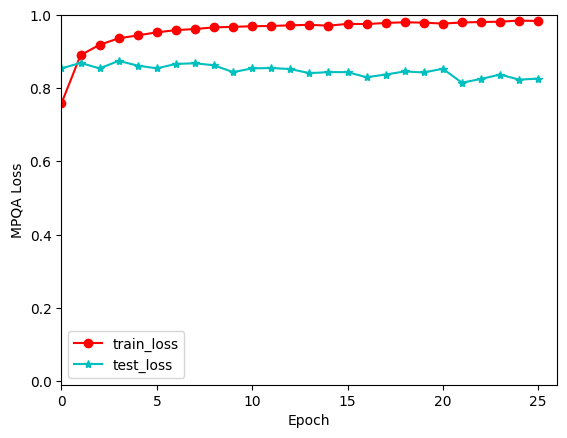

In [544]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 3
OUTPUT_DIM = 1
num_layers = 2
print("num_layers",num_layers)
# vocab_size = 19192, embedding_dim = 100, hidden_dim = 3, output_dim = 1, dropout = 0.5, pad_idx = 1
PAD_IDX = 1
print('pad_idx', PAD_IDX)

model = run_complex_network(word_vector_weight_matrix,
                            EMBEDDING_DIM,
                            HIDDEN_DIM,
                            OUTPUT_DIM,
                            num_layers,
                            PAD_IDX,
                            VOCAB_SIZE,
                            BATCH_SIZE)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

optimizer = optim.Adam(model.parameters())#优化器使用的是Adam
criterion = nn.BCELoss()

model = model.to(device)
criterion = criterion.to(device)

best_test_loss = float('inf')
best_test_acc = float('-inf')
print(0.5 > best_test_acc)

best_acc = -1
best_f1_score = -1
acc_train = []
acc_test = []
loss_train = []
loss_test = []
f1_score_test = []

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc, train_f1_score, train_recall \
        = train(model, train_iterator, optimizer, criterion, CUDA_NUMBER)

    test_loss, test_acc, test_f1_score, test_recall \
        = evaluate(model, test_iterator, criterion, CUDA_NUMBER)

    acc_train.append(train_acc)
    acc_test.append(test_acc)
    loss_train.append(train_loss)
    loss_test.append(test_loss)
    f1_score_test.append(test_f1_score)

    if test_acc > best_acc:
        best_acc = test_acc
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), 'SST_GRU_Conv_model.pt')

    # print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    # print(
    #     f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}% | Train f1_score: {train_f1_score * 100:.2f}% | Train recall: {train_recall * 100:.2f}%')
    # print(
    #     f'\t test. Loss: {test_loss:.3f} |  test. Acc: {test_acc * 100:.2f}% | Test f1_score: {test_f1_score * 100:.2f}%| best_acc: {best_acc * 100:.2f}% | Test recall: {test_recall * 100:.2f}%')

    print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t Train Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
    print(f'\t test  Loss: {test_loss:.3f} | test  Acc: {test_acc * 100:.2f}%')
    print(f'\t best  test acc: {best_test_acc * 100:.2f}%')

with open('./train/loss/' + DATA_SET + '.txt', 'w', encoding='utf-8') as f:
    for i in loss_train:
        f.write(str(i))
    f.close()

with open('./test/loss/' + DATA_SET + '.txt', 'w', encoding='utf-8') as f:
    for i in loss_test:
        f.write(str(i) + '\n')
    f.close()

with open('./test/F1_Score/' + DATA_SET + '.txt', 'w', encoding='utf-8') as f:
    for i in f1_score_test:
        f.write(str(i) + '\n')
    f.close()

with open('./test/acc/' + DATA_SET + '.txt', 'w', encoding='utf-8') as f:
    for i in acc_test:
        f.write(str(i) + '\n')
    f.close()

with open('./test/recall/' + DATA_SET + '.txt', 'w', encoding='utf-8') as f:
    for i in test_path_ls:
        f.write(str(i) + '\n')
    f.close()

#
colors1 = '#00CED1' 
colors2 = '#DC143C'
colors3 = '#FFA500'
colors4 = '#0000aFF'
colors5 = '#FF0000'

# 画初始点
plt.figure(1)
plt.xlabel('Epoch')
plt.ylabel(DATA_SET + ' Loss')
plt.plot(range(N_EPOCHS), acc_train[0:N_EPOCHS], 'r-o', label='train_loss')
plt.plot(range(N_EPOCHS), acc_test[0:N_EPOCHS], 'c-*', label='test_loss')
plt.xlim(-0.01, N_EPOCHS)
plt.ylim(-0.01, 1)
# plt.plot(range(2), sp, c=colors3)
plt.legend()
plt.savefig('pic' + DATA_SET + '.pdf', dpi=300)
plt.show()

In [545]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import warnings
print(torch.__version__)
warnings.filterwarnings("ignore")

BATCH_SIZE = 16
DATA_SET = 'MPQA'
N_EPOCHS = 26

print("DATA_SET:", DATA_SET)
CUDA_NUMBER = 0

# 0-->MR ||  1-->CR ||  2-->SST  ||  3-->SUBJ ||  4-->MPQA
dataset_dict = {}
dataset_dict['MR'] = 0
dataset_dict['CR'] = 1
dataset_dict['SST'] = 2
dataset_dict['SUBJ'] = 3
dataset_dict['MPQA'] = 4

# 设置要训练的数据集
DATASET_NUMBER = dataset_dict[DATA_SET]

train_path_ls = []
test_path_ls = []
word_vector_path_ls = []
train_path_ls.append("./DataSet/MR/train.tsv")
train_path_ls.append("./DataSet/CR/train.tsv")
train_path_ls.append("./DataSet/SST/train.tsv")
train_path_ls.append("./DataSet/SUBJ/train.tsv")
train_path_ls.append("./DataSet/MPQA/train.tsv")

test_path_ls.append("./DataSet/MR/test.tsv")
test_path_ls.append("./DataSet/CR/test.tsv")
test_path_ls.append("./DataSet/SST/test.tsv")
test_path_ls.append("./DataSet/SUBJ/test.tsv")
test_path_ls.append("./DataSet/MPQA/test.tsv")

word_vector_path_ls.append("./sub_word_vector/MR_word_vector.txt")
word_vector_path_ls.append("./sub_word_vector/CR_word_vector.txt")
word_vector_path_ls.append("./sub_word_vector/SST_word_vector.txt")
word_vector_path_ls.append("./sub_word_vector/SUBJ_word_vector.txt")
word_vector_path_ls.append("./sub_word_vector/MPQA_word_vector.txt")

# 要训练的任务级路径
train_path = train_path_ls[DATASET_NUMBER]
test_path = test_path_ls[DATASET_NUMBER]

# 词向量和W2Idx的路径
word_vector_path = word_vector_path_ls[DATASET_NUMBER]

2.0.0+cu118
DATA_SET: MPQA


In [546]:
word_dim = 100 # 词向量维度
# 获取单词到索引的映射表以及每个单词的词向量表

word_to_index = {'<unknown>': 0, '<padded>': 1}  # 根据筛选出来的词向量文件"word_vector.txt" 生成单词和索引的字典
zero_ls = [0.0 for i in range(word_dim)]
ls = [zero_ls, zero_ls]  # 用一个列表ls来存储词向量 前两个分别是 100 维的0向量，用来表示unknown_token和pad_token
index_to_word = {}
with open(word_vector_path, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        # 将刑如 "the -0.038194 -0.24487 0.72812 -0.39961..."的字符串分成对应的词和词向量，比如"the"， "-0.038194 -0.24487 0.72812 -0.39961..."
        #并且构建单词映射到整数的字典，word_to_index。 eg. 'the' : 2  ，PS：0和1分别是两个特殊字符串 unknown 和 padded的索引，the作为词向量文件中的第一个单词，所以下标为2
        word_vector = line.split()
        word_to_index[word_vector[0]] = i + 2  # 前两位由unknown和 padded分别占据
        tmp = [] # 存储一个单词的词向量，总共是100个数字
        for j, word in enumerate(word_vector):
            if j == 0: #第一个是单词，所以跳过，只需要每个单词后面的词向量
                continue
            tmp.append(float(word))
        ls.append(tmp) #每个单词的词向量又存到列表ls当中
for key, value in word_to_index.items():
    index_to_word[value] = key

word_vector_weight_matrix = torch.FloatTensor(ls) #将词向量列表转换为Tensor
print(word_vector_weight_matrix.size())
print(word_vector_weight_matrix.shape[0])
print(len(word_to_index))#word_to_index字典的关键字是英语单词，值是单词索引，例如{'<unknown>': 0,'<padded>': 1,'the': 2,',': 3,'.': 4,...}
VOCAB_SIZE = len(word_to_index) + 2

torch.Size([5568, 100])
5568
5568


In [547]:
import torch
import random
from nltk.corpus import wordnet
import nltk

# 导入AFINN情感词典
# from afinn import Afinn

# 创建Afinn对象
# afinn = Afinn()

# 1、【将句子分词，并且求句子长度】
def get_sentences(path):
    sentences = []
    batch_sentences = []
    with open(path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            # 跳过第一行的test label
            if i == 0:
                continue
            words = line.split()[:-1]  # 需要将末尾的0或者1去掉
            label = float(line.split()[-1])
            count = 0  # 统计每个句子的长度
            for word in words:
                count += 1
            tmp = (words, count, label)
            sentences.append(tmp)
    return sentences


# 根据上面得到的word_to_index,将单词转换为数字,列表形式为[ ([words_list1], len1, label1), ([words_list2], len2, label2),......],
# word_list是多个单词组成的序列

# 2、【将分词之后的单词序列变成数字序列】
def lookup_table(array_ls, word_to_index):
    sentences_tensor = []
    for i, sentence in enumerate(array_ls):
        tensor_ls = []
        # sentence[0]是一个包含多个单词的列表。sentence[0]是一个列表，里面的元素是单词。
        for word in sentence[0]:
            # word_to_index 是一个单词到索引的字典
            if word in word_to_index.keys():
                tensor_ls.append(word_to_index[word])  # 将单词转换为索引，并且索引存入张量当中
            else:
                tensor_ls.append(1)  # 如果在索引表中没找到单词，则“不认识”单词,用1下标代替, 此时unknown_token和padded_token下标都是1
        sentences_tensor.append((tensor_ls, sentence[1], sentence[2]))
    return sentences_tensor  # 得到的列表形式为[([3,8,12,123,2,9],6,1),([6,45,652345,634,2342,4],6,0)]


# 对句子进行填充，eg:16个句子组成一个batch,【每个batch的句子长度必须相等】，这里的做法是，获取batch中长度最长的句子,然后句子长度不够的append 1
# 输入 [([单词下标]，句子长度1, 标签1), ([单词下标]，句子长度2, 标签2), ....]
# eg. [([1, 2, 3],3, 0), ([2, 3], 2, 1), ...]
# 输出，[([单词下标]，句子长度1, 标签1), ([单词下标]，句子长度2, 标签2), ....]
# eg. 假设batch_size = 2
# [([1, 2, 3], 3), ([2, 3, 1], 2),...] 第二个句子列表 append 1，但是实际长度为2

# 3、【将句子进行分batch，并且将数字列表（句子）进行填充】
def pad_sentence_plus(array_ls, array_sentiment, batch_size):  # 这里的array_ls是上面函数的输出，即sentences_tensor。
    ans = 0  # j记录每个batch的第一条数据的下标
    max = array_ls[0][1]  # max为每个batch的句子最大长度.
    # 第一维为列表的第几个元素（即一个句子元组），第二维为一个元组的第一个元素（即一个元组里面的word_list），这里max初始化为第一个句子的长度。
    for i in range(len(array_ls)):
        # 需要考虑最后一个batch可能长度不够batch_size
        if (i + 1) % batch_size == 0 or i == len(array_ls) - 1:
            if array_ls[i][1] > max:
                max = array_ls[i][1]
            if (i + 1) % batch_size == 0:
                index = batch_size
            else:
                index = i - ans + 1
            for j in range(index):
                while len(array_ls[j + ans][0]) < max:
                    array_ls[j + ans][0].append(1)
                    array_sentiment[j + ans] += [0]
            # 每一次填充完毕后，需要更新标记，并再次初始化最大值
            ans = i + 1
            if ans != len(array_ls):
                max = array_ls[ans][1]
        else:
            if array_ls[i][1] > max:  # 取句子的最大长度
                max = array_ls[i][1]
    return array_ls, array_sentiment


# 输入，[([单词下标]，句子长度1, 标签1), ([单词下标]，句子长度2, 标签2), ....]
# [([1, 2, 3],3), ([2, 3, 1], 2),...]
# shuffle表示是否将每个batch打乱
# batch_first if false 表示返回的张量形状为(sentence_len,batch_size)
# if true 表示返回的张量形状为(batch_size,sentence_len)
# 这里默认采用batch_first = False,主要是为了适应nn.Embedding层的输入形状

# 4、【获得embedding的一个个batch（调整batch的的形状）的数据迭代器】
def iterator(array_ls, array_sentiment, batch_size, shuffle=True, batch_first=False):
    sentences_index_label_sentiment = []  # 存放填充后的语句列表【句子的indx表示】
    tmp_sen = []
    tmp_label = []
    tmp_sentiment = []
    for i, sentence in enumerate(array_ls):
        tmp_sen.append(sentence[0])  # 存放一个batch的【数据】
        tmp_label.append(sentence[2])  # 存放一个batch的【标签】
        tmp_sentiment.append(array_sentiment[i])
        if (i + 1) % batch_size == 0:  #
            sentences_index_label_sentiment.append((tmp_sen, tmp_label, tmp_sentiment))
            tmp_sen = []  # 清空数据
            tmp_label = []  # 清空标签
            tmp_sentiment = []

    # 最后几个样本可能不够一个batch,需要额外判断
    if len(tmp_sen) != 0:
        # # 补齐
        # for _ in range(batch_size - len(tmp_sen)):
        #     tmp_sen.append(sentence[0])
        #     tmp_label.append(sentence[2])
        #     tmp_sentiment.append(array_sentiment[1])
        sentences_index_label_sentiment.append((tmp_sen, tmp_label, tmp_sentiment))
        # # OR去掉
        # break

    if shuffle:
        random.shuffle(sentences_index_label_sentiment)  # 打乱列表中各个batch的顺序
    res = []
    # 2D张量转置
    # 2D张量转置
    if batch_first == False:
        for batch in sentences_index_label_sentiment:
            res.append((torch.LongTensor(batch[0]).t(), torch.FloatTensor(batch[1]),
                        torch.FloatTensor(batch[2]).t()))  # 函数t()求矩阵的转置
    else:
        for batch in sentences_index_label_sentiment:
            res.append((torch.LongTensor(batch[0]).t(), torch.FloatTensor(batch[1]), torch.FloatTensor(batch[2]).t()))
    return res

In [548]:
import torch
import random
from nltk.corpus import wordnet, sentiwordnet
# 下载 SentiWordNet 数据
# nltk.download('sentiwordnet')
# 加载 SentiWordNet 数据
swn_file_path = nltk.data.find('corpora/sentiwordnet/SentiWordNet_3.0.0.txt')

In [549]:
# =====================================================================================
# ================================= sentiwordnet ======================================
# =====================================================================================


def get_sentiment_score(word):
    """获取WordNet情感分数"""

    synsets = list(wordnet.synsets(word))
    if synsets:
        sentiment_scores = [
            sentiwordnet.senti_synset(s.name()).pos_score() - sentiwordnet.senti_synset(s.name()).neg_score()
            for s in synsets
        ]
        avg_sentiment_score = sum(sentiment_scores) / len(sentiment_scores)
        return avg_sentiment_score
    return 0.0


def get_word_sentiment_scores(tokenized_sentence):
    """计算已分词句子中每个单词的情感极性分数"""
    # 处理否定词
    word_scores = [get_sentiment_score(word) for word in tokenized_sentence]
    return word_scores


def get_batch_word_sentiment_scores(batch_tokenized_sentences):
    """处理一批已分词的文本并返回其中每个单词的情感极性分数"""
    batch_word_scores = []
    for sentence, _, _ in batch_tokenized_sentences:
        batch_word_scores.append(get_word_sentiment_scores(sentence))
    return batch_word_scores

In [550]:
SEED = 1234

torch.manual_seed(SEED) # 为CPU设置随机种子，生成随机数，使得每次运行程序时，生成的随机数相同
torch.cuda.manual_seed(SEED) # 为GPU设置随机种子，生成随机数，使得每次运行程序时，生成的随机数相同
torch.backends.cudnn.deterministic = True

device = torch.device(f'cuda:{CUDA_NUMBER}' if torch.cuda.is_available() else 'cpu')

In [551]:
def get_iterator(path, batch_size, word_to_index):
    # ['another', 'thing', 'i', 'don', "'t", 'like', 'is', 'that', 'some', 'of', 'the',
    # 'features', 'take', '1-2', 'seconds', 'to', 'load', 'up', '.']
    sentences = get_sentences(path)
    # ([2, 3, 4, 5, 1, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
    # 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 19, 0.0)
    # 将单词变成indx
    sentences_indx = lookup_table(sentences, word_to_index)

    # get sentiment polarity by 【AFINN】
    # afinn = Afinn()
    # sentiment_sentences_AFINN = get_batch_word_sentiment_scores_AFINN(sentences,afinn)
    # sentiment_sentences_AFINN = calculate_sentiment_for_phrases(sentences, afinn, n=3)

    # get sentiment polarity by 【sentiwordnet】
    sentiment_sentences_sentiwordnet = get_batch_word_sentiment_scores(sentences)
    sentences_padded, sentiment_sentences_padded = pad_sentence_plus(sentences_indx, sentiment_sentences_sentiwordnet,
                                                                     batch_size)

    # 把分成一个个batch，然后每个list之内有数据和标签
    Iterator_with_sentiments = iterator(sentences_padded, sentiment_sentences_padded, batch_size)

    return Iterator_with_sentiments

# 2、生成对应任务的句子的词向量
train_iterator = get_iterator(train_path, BATCH_SIZE, word_to_index)
test_iterator = get_iterator(test_path, BATCH_SIZE, word_to_index)

In [552]:
import torch.nn as nn
import numpy as np
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch

In [553]:
class projection_Euler(nn.Module):
    def __init__(self, Embedding, num_layers):
        super(projection_Euler, self).__init__()  # projection是子类名
        pass

    def forward(self, inputs):
        amplitude = inputs[0]
        phase = inputs[1]
        # ================ 变换形状和归一化处理 ================
        # -----
        amplitude_permute = amplitude.permute(1, 0, 2)
        amplitude_norm = F.normalize(amplitude_permute, 2, 2)
        # ----
        phase_permute = phase.permute(1, 0, 2)

        # ================ 计算Am和Ph分别计算实部和虚部 ================
        # --- 求欧拉展开式
        real_part = amplitude_norm * torch.cos(phase_permute)
        imag_part = amplitude_norm * torch.sin(phase_permute)

        return [real_part, imag_part]


class projection_CalculateMatrixMean(nn.Module):
    def __init__(self, Embedding_dim):
        super(projection_CalculateMatrixMean, self).__init__()
        self.mapping_Diagonal_q = nn.Linear(Embedding_dim, Embedding_dim)
        self.mapping_Diagonal_k = nn.Linear(Embedding_dim, Embedding_dim)

        self.embed_size = Embedding_dim

    def forward(self, inputs):
        Diagonal1 = inputs[0]
        Diagonal2 = inputs[1]
        Matrix = inputs[2]

        # 计算注意力分数
        attention_scores = Diagonal1 * Diagonal2
        # 迹求和
        attention_weight = torch.sum(attention_scores, dim=-1)

        # 归一化
        attention = F.softmax(attention_weight, dim=-1).unsqueeze(-1).unsqueeze(-1)

        # 加权求和
        Matrix_output = torch.sum(Matrix * attention, dim=1)

        return Matrix_output


class projection_CalculateMatrixQ(nn.Module):
    def __init__(self, Embedding_dim):
        super(projection_CalculateMatrixQ, self).__init__()
        self.Q_Linear_real1 = nn.Linear(Embedding_dim, Embedding_dim)
        self.Q_Linear_imag1 = nn.Linear(Embedding_dim, Embedding_dim)

        self.Q_Linear_real2 = nn.Linear(Embedding_dim, Embedding_dim)
        self.Q_Linear_imag2 = nn.Linear(Embedding_dim, Embedding_dim)

        self.AttentionReal = projection_CalculateMatrixMean(Embedding_dim)
        self.AttentionImag = projection_CalculateMatrixMean(Embedding_dim)

    def forward(self, inputs):
        input_real = inputs[0]  # 实部
        input_imag = inputs[1]  # 虚部
        # ==================== 1 计算对角线和密度矩阵 ====================

        # ======= 1.1 计算对角线 =======
        input_real1 = self.Q_Linear_real1(input_real)
        input_imag1 = self.Q_Linear_imag1(input_imag)

        # 获得[实部/虚部]对角线向量
        diagonal_real1 = input_real1 * input_real1 - input_imag1 * input_imag1
        diagonal_imag1 = input_real1 * input_imag1 + input_imag1 * input_real1

        # ======= 1.2 计算密度矩阵 =======
        input_real2 = self.Q_Linear_real2(input_real)
        input_imag2 = self.Q_Linear_imag2(input_imag)

        diagonal_real2 = input_real2 * input_real2 - input_imag2 * input_imag2
        diagonal_imag2 = input_real2 * input_imag2 + input_imag2 * input_real2

        real_part_expand = torch.unsqueeze(input_real2, dim=3)
        imag_part_expand = torch.unsqueeze(input_imag2, dim=3)

        real_part_expand_transpose = real_part_expand.permute(0, 1, 3, 2)
        imag_part_expand_transpose = imag_part_expand.permute(0, 1, 3, 2)

        # real 密度矩阵
        Matrix_real = torch.matmul(real_part_expand, real_part_expand_transpose) - torch.matmul(imag_part_expand,
                                                                                                imag_part_expand_transpose)
        # imag 密度矩阵
        Matrix_imag = torch.matmul(imag_part_expand, real_part_expand_transpose) + torch.matmul(real_part_expand,
                                                                                                imag_part_expand_transpose)

        Matrix_Real_output = self.AttentionReal([diagonal_real1, diagonal_real2, Matrix_real])
        Matrix_imag_output = self.AttentionImag([diagonal_imag1, diagonal_imag2, Matrix_imag])

        return [Matrix_Real_output, Matrix_imag_output]


class projection_Measurement(nn.Module):
    def __init__(self, Embedding_dim):
        super(projection_Measurement, self).__init__()  # projection是子类名
        # 使得tensor是正交的,正交初始化,projector是子类projection的新属性。
        self.projector = nn.init.orthogonal_(Parameter(torch.Tensor(2, Embedding_dim, 1)))

    def forward(self, inputs):
        v_real_avg = inputs[0]
        v_imag_avg = inputs[1]

        p_real = self.projector[0]
        p_imag = self.projector[1]

        p_real_norm = p_real / torch.norm(p_real, dim=0)
        p_imag_norm = p_imag / torch.norm(p_imag, dim=0)

        p_real_mat = torch.matmul(p_real_norm, p_real_norm.permute(1, 0))
        p_imag_mat = torch.matmul(p_imag_norm, p_imag_norm.permute(1, 0))

        Pv_real = torch.matmul(v_real_avg, p_real_mat) - torch.matmul(v_imag_avg, p_imag_mat)
        Pv_imag = torch.matmul(v_real_avg, p_imag_mat) + torch.matmul(v_imag_avg, p_real_mat)

        Pv_real_plus = torch.unsqueeze(Pv_real, dim=1)
        Pv_imag_plus = torch.unsqueeze(Pv_imag, dim=1)

        return [Pv_real_plus, Pv_imag_plus]

In [554]:
# 映射成三个不同的向量的自注意力机制
class self_attention(nn.Module):
    def __init__(self, Embedding_dim):
        super(self_attention, self).__init__()
        self.mapping_query = nn.init.uniform_(
            Parameter(torch.Tensor(Embedding_dim, Embedding_dim)))  # 从均匀分布U(a, b)中生成值（随机生成），填充输入的张量或变量
        self.mapping_key = nn.init.uniform_(Parameter(torch.Tensor(Embedding_dim, Embedding_dim)))
        self.mapping_value = nn.init.uniform_(Parameter(torch.Tensor(Embedding_dim, Embedding_dim)))

    def forward(self, inputs):
        query = torch.matmul(inputs.permute(1, 0, 2), self.mapping_query)  # permute函数为换维函数，参数为(0，1，2)
        key = torch.matmul(inputs.permute(1, 0, 2), self.mapping_key)  # matmul是tensor矩阵乘法
        value = torch.matmul(inputs.permute(1, 0, 2), self.mapping_value)

        query = query / torch.norm(query, dim=2).reshape(query.shape[0], query.shape[1],
                                                         1)  # query.shape[0]=16,query.shape[1]=sentence_length.
        key = key / torch.norm(key, dim=2).reshape(key.shape[0], key.shape[1],
                                                   1)  # shape of tensor:[16,sentence_length,1]

        value = value / torch.norm(value, dim=2).reshape(value.shape[0], value.shape[1], 1)  # query,key,value的形状是一样的

        xx = torch.matmul(query, torch.transpose(key, 1, 2)) / np.sqrt(inputs.shape[1])
        xx1 = torch.softmax(xx, dim=2)
        out = torch.matmul(xx1, value)
        return out

In [555]:
class GRUWithSkipConnection(nn.Module):
    def __init__(self, Embedding_dim, num_layers):
        super(GRUWithSkipConnection, self).__init__()

        # GRU layer
        self.rnn = nn.GRU(Embedding_dim, Embedding_dim, num_layers=num_layers, dropout=0.1)

        # self.scale_layer = nn.Linear(2 * Embedding_dim, Embedding_dim)

        # Linear layer for skip connection
        self.middle_layer = nn.Linear(Embedding_dim, Embedding_dim)

    def forward(self, x):
        # Forward pass through GRU layer
        output, _ = self.rnn(x)

        # Skip connection: Add output of middle layer to GRU layer output
        output = output + self.middle_layer(x)

        return output

In [556]:
# -------------------- 01 Model_best_copy8672_cnn_maxpooling ------------------------
print("Model_best_copy8672_cnn_maxpooling")
class run_complex_network(nn.Module):
    def __init__(self, weight_matrix, embedding_dim, hidden_dim, output_dim, num_layers, pad_idx, VOCAB_SIZE, batch):
        super().__init__()

        # ================ 1、词嵌入模块 ================
        # ------ 实部，预训练模型 -------
        self.amplitude_embedding = nn.Embedding.from_pretrained(weight_matrix, padding_idx=pad_idx, freeze=False)
        # self.amplitude_embedding2 = nn.Embedding(VOCAB_SIZE, embedding_dim, padding_idx=pad_idx)

        # ------ 虚部，传统模型 -------
        # self.phase_embedding = nn.Embedding.from_pretrained(weight_matrix, padding_idx=pad_idx, freeze=False)
        # self.phase_embedding = nn.Embedding(VOCAB_SIZE, embedding_dim, padding_idx=pad_idx)
        # self.phase_embedding_sentiment = nn.Embedding(VOCAB_SIZE, embedding_dim, padding_idx=pad_idx)

        # ================ 2、GRU模块 信息提取 ================
        # 输出张量的维度(L:sequence_length,N:batch_size,hidden_size)
        self.gru1 = GRUWithSkipConnection(embedding_dim, num_layers)
        self.gru2 = GRUWithSkipConnection(embedding_dim, num_layers)

        self.self_attention1 = self_attention(Embedding_dim=embedding_dim)
        # ================ 3、计算密度矩阵 ================

        self.projection_Euler = projection_Euler(Embedding=embedding_dim, num_layers=num_layers)
        self.projection_CalculateMatrixattension = projection_CalculateMatrixQ(Embedding_dim=embedding_dim)
        self.projection_measurement = projection_Measurement(embedding_dim)

        # ================ 4、卷积 ================
        self.Conv2dOne = nn.Conv2d(1, 1, 3)  # 实部
        self.Conv2dTwo = nn.Conv2d(1, 1, 3)  # 虚部

        # ================ 5、池化 ================

        self.MaxPool1 = nn.MaxPool2d((embedding_dim - 2, 1), 1)  # 实部
        self.MaxPool2 = nn.MaxPool2d((embedding_dim - 2, 1), 1)  # 虚部

        # ================ 6、全连接层 ================
        self.fc1 = nn.Linear(2 * (embedding_dim - 2), 10)
        self.fc2 = nn.Linear(10, output_dim)

    def forward(self, text, sentiment):
        # ================ 1、文本嵌入到向量 ================
        amplitude_is_WordEmbedding = self.amplitude_embedding(text)

        sentiment_unsqueeze = (torch.unsqueeze(sentiment, dim=-1).
                               expand(*sentiment.shape, amplitude_is_WordEmbedding.size(2)))

        phase_is_sentiment = sentiment_unsqueeze

        # ================ 2、实部进行GRU处理 ================
        amplitude_plus = self.gru1(amplitude_is_WordEmbedding)
        amplitude_plus2 = self.self_attention1(amplitude_plus)
        amplitude_plus2 = amplitude_plus2.permute(1, 0, 2)

        phase_plus = self.gru2(phase_is_sentiment)

        # ================ 3、计算密度矩阵 ================
        embedded = [amplitude_plus2, phase_plus]

        Euler_realAimag = self.projection_Euler(embedded)
        Matrix_realAimag = self.projection_CalculateMatrixattension(Euler_realAimag)
        Project_realAimag = self.projection_measurement(Matrix_realAimag)

        MatrixReal = Project_realAimag[0]
        MatrixImag = Project_realAimag[1]

        # ================ 4、卷积操作 ================
        # 5.1 --对于【实部】进行卷积
        Conv_real = self.Conv2dOne(MatrixReal)
        # 5.2 --对于【虚部】进行卷积
        Conv_imag = self.Conv2dTwo(MatrixImag)

        # ================ 5、池化操作 ================
        # 6.1 --对于【实部】进行池化
        Max_real = self.MaxPool1(torch.sigmoid(Conv_real))
        # 6.2 --对于【虚部】进行池化
        Max_imag = self.MaxPool2(torch.sigmoid(Conv_imag))

        # ================ 6、全连接 ================
        fc1 = self.fc1(torch.cat((Max_real, Max_imag), dim=3))
        fc2 = torch.sigmoid(self.fc2(torch.sigmoid(fc1)))

        return fc2
    
# ===================== 02 Model_best_copy8672_cnn_diagonal =====================

# print("Model_best_copy8672_cnn_diagonal")
# class run_complex_network(nn.Module):
#     def __init__(self, weight_matrix, embedding_dim, hidden_dim, output_dim, num_layers, pad_idx, VOCAB_SIZE, batch):
#         super().__init__()

#         # ================ 1、词嵌入模块 ================
#         # ------ 实部，预训练模型 -------
#         self.amplitude_embedding = nn.Embedding.from_pretrained(weight_matrix, padding_idx=pad_idx, freeze=False)
#         # self.amplitude_embedding2 = nn.Embedding(VOCAB_SIZE, embedding_dim, padding_idx=pad_idx)

#         # ------ 虚部，传统模型 -------
#         # self.phase_embedding = nn.Embedding.from_pretrained(weight_matrix, padding_idx=pad_idx, freeze=False)
#         # self.phase_embedding = nn.Embedding(VOCAB_SIZE, embedding_dim, padding_idx=pad_idx)
#         # self.phase_embedding_sentiment = nn.Embedding(VOCAB_SIZE, embedding_dim, padding_idx=pad_idx)

#         # ================ 2、GRU模块 信息提取 ================
#         # 输出张量的维度(L:sequence_length,N:batch_size,hidden_size)
#         self.gru1 = GRUWithSkipConnection(embedding_dim, num_layers)
#         self.self_attention1 = self_attention(Embedding_dim=embedding_dim)
#         self.gru2 = GRUWithSkipConnection(embedding_dim, num_layers)
#         # self.self_attention2 = self_attention(Embedding_dim=embedding_dim)
#         # ================ 3、计算密度矩阵 ================

#         self.projection_Euler = projection_Euler(Embedding=embedding_dim, num_layers=num_layers)
#         self.projection_CalculateMatrixattension = projection_CalculateMatrixQ(Embedding_dim=embedding_dim)
#         self.projection_measurement = projection_Measurement(embedding_dim)

#         # ================ 4、卷积 ================
#         self.Conv2dOne = nn.Conv2d(1, 1, 3)  # 实部
#         self.Conv2dTwo = nn.Conv2d(1, 1, 3)  # 虚部

#         # ================ 6、全连接层 ================
#         self.fc1 = nn.Linear(2 * (embedding_dim-2), 10)
#         self.fc2 = nn.Linear(10, output_dim)

#     def forward(self, text, sentiment):
#         # ================ 1、文本嵌入到向量 ================
#         amplitude_is_WordEmbedding = self.amplitude_embedding(text)

#         sentiment_unsqueeze = (torch.unsqueeze(sentiment, dim=-1).
#                                expand(*sentiment.shape, amplitude_is_WordEmbedding.size(2)))

#         phase_is_sentiment = sentiment_unsqueeze
#         # phase_is_sentiment = self.phase_embedding(text)
#         # ================ 2、实部进行GRU处理 ================
#         amplitude_plus = self.gru1(amplitude_is_WordEmbedding)
#         amplitude_plus2 = self.self_attention1(amplitude_plus)
#         amplitude_plus2 = amplitude_plus2.permute(1, 0, 2)

#         phase_plus = self.gru2(phase_is_sentiment)
#         # phase_plus2 = self.self_attention2(phase_plus)
#         # phase_plus2 = phase_plus2.permute(1, 0, 2)
#         # ================ 3、计算密度矩阵 ================
#         embedded = [amplitude_plus2, phase_plus]

#         Euler_realAimag = self.projection_Euler(embedded)
#         Matrix_realAimag = self.projection_CalculateMatrixattension(Euler_realAimag)
#         Project_realAimag = self.projection_measurement(Matrix_realAimag)

#         MatrixReal = Project_realAimag[0]
#         MatrixImag = Project_realAimag[1]

#         # ================ 4、卷积操作 ================
#         # 5.1 --对于【实部】进行卷积
#         Conv_real = self.Conv2dOne(MatrixReal)
#         # 5.2 --对于【虚部】进行卷积
#         Conv_imag = self.Conv2dTwo(MatrixImag)

#         # ================ 5、取对角线 ================
#         diagonal_elements_real = Conv_real[:, 0, torch.arange(Conv_real.size(2)), torch.arange(Conv_real.size(3))]
#         diagonal_elements_imag = Conv_imag[:, 0, torch.arange(Conv_imag.size(2)), torch.arange(Conv_imag.size(3))]

#         diagonal_elements_real = diagonal_elements_real.unsqueeze(1).unsqueeze(1)
#         diagonal_elements_imag = diagonal_elements_imag.unsqueeze(1).unsqueeze(1)

#         # ================ 6、全连接 ================
#         diagonal_elements_cat = torch.cat((diagonal_elements_real, diagonal_elements_imag), dim=3)
#         fc1 = torch.sigmoid(self.fc1(diagonal_elements_cat))
#         fc2 = torch.sigmoid(self.fc2(fc1))

#         return fc2

Model_best_copy8672_cnn_maxpooling


In [557]:
# ===================== 03 Model_best_copy8672_diagonal =====================
# print("Model_best_copy8672_diagonal")
    
# class run_complex_network(nn.Module):
#     def __init__(self, weight_matrix, embedding_dim, hidden_dim, output_dim, num_layers, pad_idx, VOCAB_SIZE, batch):
#         super().__init__()

#         # ================ 1、词嵌入模块 ================
#         # ------ 实部，预训练模型 -------
#         self.amplitude_embedding = nn.Embedding.from_pretrained(weight_matrix, padding_idx=pad_idx, freeze=False)
#         # self.amplitude_embedding2 = nn.Embedding(VOCAB_SIZE, embedding_dim, padding_idx=pad_idx)

#         # ------ 虚部，传统模型 -------
#         # self.phase_embedding = nn.Embedding.from_pretrained(weight_matrix, padding_idx=pad_idx, freeze=False)
#         # self.phase_embedding = nn.Embedding(VOCAB_SIZE, embedding_dim, padding_idx=pad_idx)
#         # self.phase_embedding_sentiment = nn.Embedding(VOCAB_SIZE, embedding_dim, padding_idx=pad_idx)

#         # ================ 2、GRU模块 信息提取 ================
#         # 输出张量的维度(L:sequence_length,N:batch_size,hidden_size)
#         self.gru1 = GRUWithSkipConnection(embedding_dim, num_layers)
#         self.self_attention1 = self_attention(Embedding_dim=embedding_dim)
#         self.gru2 = GRUWithSkipConnection(embedding_dim, num_layers)
#         # self.self_attention2 = self_attention(Embedding_dim=embedding_dim)
#         # ================ 3、计算密度矩阵 ================

#         self.projection_Euler = projection_Euler(Embedding=embedding_dim, num_layers=num_layers)
#         self.projection_CalculateMatrixattension = projection_CalculateMatrixQ(Embedding_dim=embedding_dim)
#         self.projection_measurement = projection_Measurement(embedding_dim)

#         # ================ 4、全连接层 ================
#         self.fc1 = nn.Linear(2 * embedding_dim, 10)
#         self.fc2 = nn.Linear(10, output_dim)

#     def forward(self, text, sentiment):
#         # ================ 1、文本嵌入到向量 ================
#         amplitude_is_WordEmbedding = self.amplitude_embedding(text)

#         sentiment_unsqueeze = (torch.unsqueeze(sentiment, dim=-1).
#                                expand(*sentiment.shape, amplitude_is_WordEmbedding.size(2)))

#         phase_is_sentiment = sentiment_unsqueeze
#         # phase_is_sentiment = self.phase_embedding(text)
#         # ================ 2、实部进行GRU处理 ================
#         amplitude_plus = self.gru1(amplitude_is_WordEmbedding)
#         amplitude_plus2 = self.self_attention1(amplitude_plus)
#         amplitude_plus2 = amplitude_plus2.permute(1, 0, 2)

#         phase_plus = self.gru2(phase_is_sentiment)
#         # phase_plus2 = self.self_attention2(phase_plus)
#         # phase_plus2 = phase_plus2.permute(1, 0, 2)
#         # ================ 3、计算密度矩阵 ================
#         embedded = [amplitude_plus2, phase_plus]

#         Euler_realAimag = self.projection_Euler(embedded)
#         Matrix_realAimag = self.projection_CalculateMatrixattension(Euler_realAimag)
#         Project_realAimag = self.projection_measurement(Matrix_realAimag)

#         MatrixReal = Project_realAimag[0]
#         MatrixImag = Project_realAimag[1]

#         # ================ 4、取对角线 ================
#         diagonal_elements_real = MatrixReal[:, 0, torch.arange(MatrixReal.size(2)), torch.arange(MatrixReal.size(3))]
#         diagonal_elements_imag = MatrixImag[:, 0, torch.arange(MatrixImag.size(2)), torch.arange(MatrixImag.size(3))]
#         diagonal_elements_real = diagonal_elements_real.unsqueeze(1).unsqueeze(1)
#         diagonal_elements_imag = diagonal_elements_imag.unsqueeze(1).unsqueeze(1)

#         # ================ 5、全连接 ================
#         diagonal_elements_cat = torch.cat((diagonal_elements_real, diagonal_elements_imag), dim=3)
#         fc1 = torch.sigmoid(self.fc1(diagonal_elements_cat))
#         fc2 = torch.sigmoid(self.fc2(fc1))

#         return fc2

In [558]:
# ===================== 04 Model_best_copy8672_maxpooling =====================
# print("Model_best_copy8672_maxpooling")
# class run_complex_network(nn.Module):
#     def __init__(self, weight_matrix, embedding_dim, hidden_dim, output_dim, num_layers, pad_idx, VOCAB_SIZE, batch):
#         super().__init__()

#         # ================ 1、词嵌入模块 ================
#         # ------ 实部，预训练模型 -------
#         self.amplitude_embedding = nn.Embedding.from_pretrained(weight_matrix, padding_idx=pad_idx, freeze=False)
#         # self.amplitude_embedding2 = nn.Embedding(VOCAB_SIZE, embedding_dim, padding_idx=pad_idx)

#         # ------ 虚部，传统模型 -------
#         # self.phase_embedding = nn.Embedding.from_pretrained(weight_matrix, padding_idx=pad_idx, freeze=False)
#         # self.phase_embedding = nn.Embedding(VOCAB_SIZE, embedding_dim, padding_idx=pad_idx)
#         # self.phase_embedding_sentiment = nn.Embedding(VOCAB_SIZE, embedding_dim, padding_idx=pad_idx)

#         # ================ 2、GRU模块 信息提取 ================
#         # 输出张量的维度(L:sequence_length,N:batch_size,hidden_size)
#         self.gru1 = GRUWithSkipConnection(embedding_dim, num_layers)
#         self.self_attention1 = self_attention(Embedding_dim=embedding_dim)
#         self.gru2 = GRUWithSkipConnection(embedding_dim, num_layers)
#         # self.self_attention2 = self_attention(Embedding_dim=embedding_dim)
#         # ================ 3、计算密度矩阵 ================

#         self.projection_Euler = projection_Euler(Embedding=embedding_dim, num_layers=num_layers)
#         self.projection_CalculateMatrixattension = projection_CalculateMatrixQ(Embedding_dim=embedding_dim)
#         self.projection_measurement = projection_Measurement(embedding_dim)

#         # ================ 4、池化 ================
#         # self.avgPool1 = nn.AvgPool2d((embedding_dim - 2, 1), 1)
#         # self.avgPool2 = nn.AvgPool2d((embedding_dim - 2, 1), 1)
#         self.MaxPool1 = nn.MaxPool2d((embedding_dim, 1), 1)  # 实部
#         self.MaxPool2 = nn.MaxPool2d((embedding_dim, 1), 1)  # 虚部

#         # ================ 5、全连接层 ================
#         self.fc1 = nn.Linear(2 * embedding_dim, 10)
#         self.fc2 = nn.Linear(10, output_dim)

#     def forward(self, text, sentiment):
#         # ================ 1、文本嵌入到向量 ================
#         amplitude_is_WordEmbedding = self.amplitude_embedding(text)

#         sentiment_unsqueeze = (torch.unsqueeze(sentiment, dim=-1).
#                                expand(*sentiment.shape, amplitude_is_WordEmbedding.size(2)))

#         phase_is_sentiment = sentiment_unsqueeze
#         # phase_is_sentiment = self.phase_embedding(text)
#         # ================ 2、实部进行GRU处理 ================
#         amplitude_plus = self.gru1(amplitude_is_WordEmbedding)
#         amplitude_plus2 = self.self_attention1(amplitude_plus)
#         amplitude_plus2 = amplitude_plus2.permute(1, 0, 2)

#         phase_plus = self.gru2(phase_is_sentiment)
#         # phase_plus2 = self.self_attention2(phase_plus)
#         # phase_plus2 = phase_plus2.permute(1, 0, 2)
#         # ================ 3、计算密度矩阵 ================
#         embedded = [amplitude_plus2, phase_plus]

#         Euler_realAimag = self.projection_Euler(embedded)
#         Matrix_realAimag = self.projection_CalculateMatrixattension(Euler_realAimag)
#         Project_realAimag = self.projection_measurement(Matrix_realAimag)

#         MatrixReal = Project_realAimag[0]
#         MatrixImag = Project_realAimag[1]

#         # ================ 5、池化操作 ================
#         # 6.1 --对于【实部】进行池化
#         Max_real = self.MaxPool1(torch.sigmoid(MatrixReal))
#         # 6.2 --对于【虚部】进行池化
#         Max_imag = self.MaxPool2(torch.sigmoid(MatrixImag))

#         # ================ 6、全连接 ================
#         fc1 = self.fc1(torch.cat((Max_real, Max_imag), dim=3))
#         fc2 = torch.sigmoid(self.fc2(torch.sigmoid(fc1)))

#         return fc2

In [559]:
from sklearn.metrics import f1_score
def multiply(input1, input2):
    return torch.sum(torch.mul(input1, input2)).item()

def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
#     print(f'preds:{preds}, y:{y}')
    correct = (rounded_preds == y).float() #convert into float for division
    # print('batch: 模型预测值', rounded_preds,'真实标签', y)
    acc = correct.sum() / len(correct)
    return acc

def calculation_recall(preds, y):
    pre = preds.detach()
    pre_y = y.detach()
    rounded_preds = torch.round(pre)
    
    TP = (torch.from_numpy(rounded_preds.cpu().numpy().astype(int)) & torch.from_numpy(pre_y.cpu().numpy().astype(int))).sum()
    recall = TP / (y.cpu().sum())
    return recall

def f1_score_avg(preds, y):
    rounded_preds = torch.round(preds)
    f1_score(y, rounded_preds, 'macro')

# 定义训练流程
# 把训练数据投入模型进行训练
def train(model, iterator, optimizer, criterion, CUDA_NUMBER):
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1_score = 0
    epoch_recall = 0
    model.train()

    for i, batch in enumerate(iterator):
        text = batch[0].cuda(CUDA_NUMBER)
        label = batch[1].cuda(CUDA_NUMBER)
        sentiment = batch[2].cuda(CUDA_NUMBER)

        optimizer.zero_grad()

        predictions = model(text, sentiment).squeeze(1)
        # print(predictions)
        loss = criterion(predictions.reshape(len(label)), label)

        acc = binary_accuracy(predictions.reshape(len(label)), label)

        recall = calculation_recall(predictions.reshape(len(label)), label)

        label_score = label.tolist()

        y_true = label_score.copy()

        predictions_score = torch.round(predictions.reshape(len(label))).tolist()

        y_pred = predictions_score.copy()

        F1Score = f1_score(y_true, y_pred)

        loss.backward()

        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()

        epoch_loss += loss.item()

        epoch_acc += acc.item()

        epoch_recall += recall.item()

        epoch_f1_score += F1Score.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_f1_score / len(
        iterator), epoch_recall / len(iterator)

# 评价
def evaluate(model, iterator, criterion, CUDA_NUMBER):
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1_score = 0
    epoch_recall = 0
    model.eval()

    with torch.no_grad():
        for batch in iterator:
            text = batch[0].cuda(CUDA_NUMBER)
            label = batch[1].cuda(CUDA_NUMBER)
            sentiment = batch[2].cuda(CUDA_NUMBER)

            predictions = model(text, sentiment).squeeze(1)

            loss = criterion(predictions.reshape(len(label)), label)

            acc = binary_accuracy(predictions.reshape(len(label)), label)

            recall = calculation_recall(predictions.reshape(len(label)), label)

            label_score = label.tolist()
            y_true = label_score.copy()
            predictions_score = torch.round(predictions.reshape(len(label))).tolist()
            y_pred = predictions_score.copy()
            F1Score = f1_score(y_true, y_pred)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_f1_score += F1Score.item()
            epoch_recall += recall.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_f1_score / len(
        iterator), epoch_recall / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

num_layers 2
pad_idx 1
The model has 932,401 trainable parameters
True
Epoch: 01 | Epoch Time: 0m 10s
	 Train Loss: 0.519 | Train Acc: 76.25%
	 test  Loss: 0.397 | test  Acc: 85.82%
	 best  test acc: 85.82%
Epoch: 02 | Epoch Time: 0m 9s
	 Train Loss: 0.329 | Train Acc: 88.72%
	 test  Loss: 0.345 | test  Acc: 86.75%
	 best  test acc: 86.75%
Epoch: 03 | Epoch Time: 0m 9s
	 Train Loss: 0.256 | Train Acc: 91.65%
	 test  Loss: 0.361 | test  Acc: 87.03%
	 best  test acc: 87.03%
Epoch: 04 | Epoch Time: 0m 9s
	 Train Loss: 0.213 | Train Acc: 93.57%
	 test  Loss: 0.363 | test  Acc: 87.50%
	 best  test acc: 87.50%
Epoch: 05 | Epoch Time: 0m 8s
	 Train Loss: 0.183 | Train Acc: 94.90%
	 test  Loss: 0.384 | test  Acc: 86.85%
	 best  test acc: 87.50%
Epoch: 06 | Epoch Time: 0m 8s
	 Train Loss: 0.174 | Train Acc: 94.96%
	 test  Loss: 0.444 | test  Acc: 85.63%
	 best  test acc: 87.50%
Epoch: 07 | Epoch Time: 0m 9s
	 Train Loss: 0.168 | Train Acc: 95.32%
	 test  Loss: 0.394 | test  Acc: 86.01%
	 best  

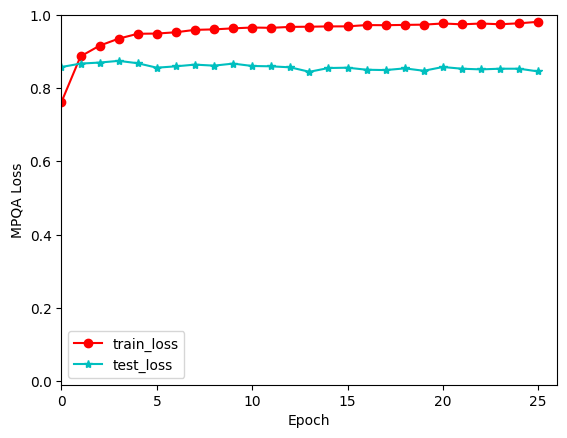

In [560]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 3
OUTPUT_DIM = 1
num_layers = 2
print("num_layers",num_layers)
# vocab_size = 19192, embedding_dim = 100, hidden_dim = 3, output_dim = 1, dropout = 0.5, pad_idx = 1
PAD_IDX = 1
print('pad_idx', PAD_IDX)

model = run_complex_network(word_vector_weight_matrix,
                            EMBEDDING_DIM,
                            HIDDEN_DIM,
                            OUTPUT_DIM,
                            num_layers,
                            PAD_IDX,
                            VOCAB_SIZE,
                            BATCH_SIZE)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

optimizer = optim.Adam(model.parameters())#优化器使用的是Adam
criterion = nn.BCELoss()

model = model.to(device)
criterion = criterion.to(device)

best_test_loss = float('inf')
best_test_acc = float('-inf')
print(0.5 > best_test_acc)

best_acc = -1
best_f1_score = -1
acc_train = []
acc_test = []
loss_train = []
loss_test = []
f1_score_test = []

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc, train_f1_score, train_recall \
        = train(model, train_iterator, optimizer, criterion, CUDA_NUMBER)

    test_loss, test_acc, test_f1_score, test_recall \
        = evaluate(model, test_iterator, criterion, CUDA_NUMBER)

    acc_train.append(train_acc)
    acc_test.append(test_acc)
    loss_train.append(train_loss)
    loss_test.append(test_loss)
    f1_score_test.append(test_f1_score)

    if test_acc > best_acc:
        best_acc = test_acc
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), 'SST_GRU_Conv_model.pt')

    # print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    # print(
    #     f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}% | Train f1_score: {train_f1_score * 100:.2f}% | Train recall: {train_recall * 100:.2f}%')
    # print(
    #     f'\t test. Loss: {test_loss:.3f} |  test. Acc: {test_acc * 100:.2f}% | Test f1_score: {test_f1_score * 100:.2f}%| best_acc: {best_acc * 100:.2f}% | Test recall: {test_recall * 100:.2f}%')

    print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t Train Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
    print(f'\t test  Loss: {test_loss:.3f} | test  Acc: {test_acc * 100:.2f}%')
    print(f'\t best  test acc: {best_test_acc * 100:.2f}%')

with open('./train/loss/' + DATA_SET + '.txt', 'w', encoding='utf-8') as f:
    for i in loss_train:
        f.write(str(i))
    f.close()

with open('./test/loss/' + DATA_SET + '.txt', 'w', encoding='utf-8') as f:
    for i in loss_test:
        f.write(str(i) + '\n')
    f.close()

with open('./test/F1_Score/' + DATA_SET + '.txt', 'w', encoding='utf-8') as f:
    for i in f1_score_test:
        f.write(str(i) + '\n')
    f.close()

with open('./test/acc/' + DATA_SET + '.txt', 'w', encoding='utf-8') as f:
    for i in acc_test:
        f.write(str(i) + '\n')
    f.close()

with open('./test/recall/' + DATA_SET + '.txt', 'w', encoding='utf-8') as f:
    for i in test_path_ls:
        f.write(str(i) + '\n')
    f.close()

#
colors1 = '#00CED1' 
colors2 = '#DC143C'
colors3 = '#FFA500'
colors4 = '#0000aFF'
colors5 = '#FF0000'

# 画初始点
plt.figure(1)
plt.xlabel('Epoch')
plt.ylabel(DATA_SET + ' Loss')
plt.plot(range(N_EPOCHS), acc_train[0:N_EPOCHS], 'r-o', label='train_loss')
plt.plot(range(N_EPOCHS), acc_test[0:N_EPOCHS], 'c-*', label='test_loss')
plt.xlim(-0.01, N_EPOCHS)
plt.ylim(-0.01, 1)
# plt.plot(range(2), sp, c=colors3)
plt.legend()
plt.savefig('pic' + DATA_SET + '.pdf', dpi=300)
plt.show()